In [42]:
import os
import findspark
findspark.init(os.getenv('SPARK_HOME'))
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
spark = SparkSession.builder.appName("cluster_exp").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/26 09:42:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/26 09:42:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
data = spark.read.csv("seeds_dataset.csv", header=True, inferSchema=True)
data.show()

+-----+---------+-----------+------------------+------------------+---------------------+------------------+
| area|perimeter|compactness|  length_of_kernel|   width_of_kernel|asymmetry_coefficient|  length_of_groove|
+-----+---------+-----------+------------------+------------------+---------------------+------------------+
|15.26|    14.84|      0.871|             5.763|             3.312|                2.221|              5.22|
|14.88|    14.57|     0.8811| 5.553999999999999|             3.333|                1.018|             4.956|
|14.29|    14.09|      0.905|             5.291|3.3369999999999997|                2.699|             4.825|
|13.84|    13.94|     0.8955|             5.324|3.3789999999999996|                2.259|             4.805|
|16.14|    14.99|     0.9034|5.6579999999999995|             3.562|                1.355|             5.175|
|14.38|    14.21|     0.8951|             5.386|             3.312|   2.4619999999999997|             4.956|
|14.69|    14.49|  

In [5]:
data.describe().show()

+-------+------------------+------------------+--------------------+-------------------+------------------+---------------------+-------------------+
|summary|              area|         perimeter|         compactness|   length_of_kernel|   width_of_kernel|asymmetry_coefficient|   length_of_groove|
+-------+------------------+------------------+--------------------+-------------------+------------------+---------------------+-------------------+
|  count|               210|               210|                 210|                210|               210|                  210|                210|
|   mean|14.847523809523816|14.559285714285718|  0.8709985714285714|  5.628533333333335| 3.258604761904762|   3.7001999999999997|  5.408071428571429|
| stddev|2.9096994306873647|1.3059587265640225|0.023629416583846364|0.44306347772644983|0.3777144449065867|   1.5035589702547392|0.49148049910240543|
|    min|             10.59|             12.41|              0.8081|              4.899|            

In [7]:
assembler = VectorAssembler(inputCols=data.columns, outputCol='features')

In [10]:
data = assembler.transform(data)
data.show()

+-----+---------+-----------+------------------+------------------+---------------------+------------------+--------------------+
| area|perimeter|compactness|  length_of_kernel|   width_of_kernel|asymmetry_coefficient|  length_of_groove|            features|
+-----+---------+-----------+------------------+------------------+---------------------+------------------+--------------------+
|15.26|    14.84|      0.871|             5.763|             3.312|                2.221|              5.22|[15.26,14.84,0.87...|
|14.88|    14.57|     0.8811| 5.553999999999999|             3.333|                1.018|             4.956|[14.88,14.57,0.88...|
|14.29|    14.09|      0.905|             5.291|3.3369999999999997|                2.699|             4.825|[14.29,14.09,0.90...|
|13.84|    13.94|     0.8955|             5.324|3.3789999999999996|                2.259|             4.805|[13.84,13.94,0.89...|
|16.14|    14.99|     0.9034|5.6579999999999995|             3.562|                1.355| 

In [12]:
scaler = StandardScaler(inputCol='features', outputCol='scaled')

In [14]:
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)
data.show()

+-----+---------+-----------+------------------+------------------+---------------------+------------------+--------------------+--------------------+
| area|perimeter|compactness|  length_of_kernel|   width_of_kernel|asymmetry_coefficient|  length_of_groove|            features|              scaled|
+-----+---------+-----------+------------------+------------------+---------------------+------------------+--------------------+--------------------+
|15.26|    14.84|      0.871|             5.763|             3.312|                2.221|              5.22|[15.26,14.84,0.87...|[5.24452795332028...|
|14.88|    14.57|     0.8811| 5.553999999999999|             3.333|                1.018|             4.956|[14.88,14.57,0.88...|[5.11393027165175...|
|14.29|    14.09|      0.905|             5.291|3.3369999999999997|                2.699|             4.825|[14.29,14.09,0.90...|[4.91116018695588...|
|13.84|    13.94|     0.8955|             5.324|3.3789999999999996|                2.259|     

In [21]:
wss = []
for k in range(2, 20):
    kmeans = KMeans(featuresCol='scaled', k=k)
    model = kmeans.fit(data)
    wss.append(model.summary.trainingCost)

22/08/26 09:57:32 ERROR ContextCleaner: Error cleaning shuffle 2
java.lang.NullPointerException
	at org.apache.spark.MapOutputTrackerMaster.$anonfun$unregisterShuffle$1(MapOutputTracker.scala:882)
	at org.apache.spark.MapOutputTrackerMaster.$anonfun$unregisterShuffle$1$adapted(MapOutputTracker.scala:881)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.MapOutputTrackerMaster.unregisterShuffle(MapOutputTracker.scala:881)
	at org.apache.spark.ContextCleaner.doCleanupShuffle(ContextCleaner.scala:241)
	at org.apache.spark.ContextCleaner.$anonfun$keepCleaning$3(ContextCleaner.scala:202)
	at org.apache.spark.ContextCleaner.$anonfun$keepCleaning$3$adapted(ContextCleaner.scala:195)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.ContextCleaner.$anonfun$keepCleaning$1(ContextCleaner.scala:195)
	at org.apache.spark.util.Utils$.tryOrStopSparkContext(Utils.scala:1446)
	at org.apache.spark.ContextCleaner.org$apache$spark$ContextCleaner$$keepCleaning(ContextCleaner.sca

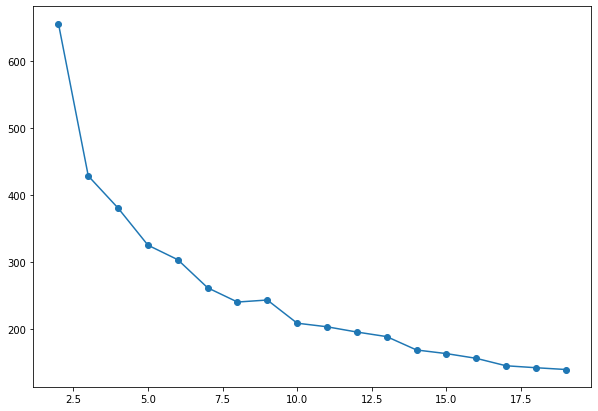

In [28]:
plt.figure(figsize=(10, 7))
plt.plot(range(2, 20), wss, marker='o')

In [53]:
kmeans = KMeans(featuresCol='scaled', k=5)
model = kmeans.fit(data)
results = model.transform(data).select('prediction')

In [54]:
results.show()

+----------+
|prediction|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         4|
|         4|
|         4|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         2|
+----------+
only showing top 20 rows



In [55]:
centers = model.clusterCenters()

In [56]:
df = pd.DataFrame(centers, columns=data.columns[:-2])
df

,area,perimeter,compactness,length_of_kernel,width_of_kernel,asymmetry_coefficient,length_of_groove
0,4.885728,10.883575,37.372414,12.324682,8.584439,1.619945,10.278468
1,6.581794,12.610786,37.541747,14.148885,9.988862,2.301484,12.466924
2,4.220784,10.214486,36.659749,11.767313,7.861157,3.526360,10.267247
3,3.993883,10.125703,35.319641,11.874709,7.328817,2.919224,10.488209
4,5.636914,11.748800,37.029531,13.304624,9.124207,2.620518,11.630868
